# 5. 2026 Forecasting & Seasonality Analysis


## Load Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from datetime import datetime, timedelta
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set plotting style for better visuals
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [2]:
# Load the processed data from preprocessing step
df_clean = pd.read_csv('../data/processed_features.csv')
df_clean['booking_date'] = pd.to_datetime(df_clean['booking_date'])

print(f"Loaded {len(df_clean):,} rows")
print(f"Date range: {df_clean['booking_date'].min().date()} to {df_clean['booking_date'].max().date()}")

Loaded 14,551 rows
Date range: 2021-01-07 to 2025-12-30


In [3]:
# Load configuration (feature names, target columns, label encoder)
with open('../data/preprocessing_config.pkl', 'rb') as f:
    config = pickle.load(f)

feature_cols = config['feature_cols']
target_columns = config['target_columns']
le = config['label_encoder']

print(f"Features: {len(feature_cols)}")
print(f"Target columns: {target_columns}")

Features: 16
Target columns: ['Air', 'Express', 'International', 'Surface']


In [4]:
# Load original raw data for creating df_daily
df = pd.read_csv('../data/shipment_booking_data_2021_2025.csv')
df['booking_date'] = pd.to_datetime(df['booking_date'])

companies = df['company_name'].unique()
print(f"Total companies: {len(companies)}")
print(f"Companies: {list(companies)}")

Total companies: 8
Companies: ['BlueDart', 'Delhivery', 'DTDC', 'FedEx India', 'DHL Express', 'XpressBees', 'Ecom Express', 'Shadowfax']


---
## Part 1: Retrain Final Models on Full Dataset

Train on ALL available data (2021-2025) for best 2026 predictions.

In [5]:
# Retrain final models using the complete dataset
final_models = {}

print("Training final models on full dataset (2021-2025)...\n")
print("="*70)

for target in target_columns:
    print(f"Training {target}...", end=" ")
    
    # Create and train XGBoost model
    model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        random_state=42
    )
    model.fit(df_clean[feature_cols], df_clean[f'target_{target}'])
    final_models[target] = model
    
    print("✓")

print("\n" + "="*70)
print("✓ Final models trained on complete dataset")
print("="*70)

Training final models on full dataset (2021-2025)...

Training Air... ✓
Training Express... ✓
Training International... ✓
Training Surface... ✓

✓ Final models trained on complete dataset


---
## Part 2: Recursive 2026 Forecast

Predict all 365 days of 2026 using recursive forecasting.

In [6]:
# Recreate df_daily for simulation purposes
df_daily = df.set_index('booking_date').groupby([
    'company_name', 
    pd.Grouper(freq='D')
])['shipment_type'].value_counts().unstack(fill_value=0).reset_index()

df_daily.columns.name = None
df_daily = df_daily.sort_values(['company_name', 'booking_date']).reset_index(drop=True)

# Make sure all shipment types exist
for col in target_columns:
    if col not in df_daily.columns:
        df_daily[col] = 0

# Add company encoding
df_daily['company_encoded'] = le.transform(df_daily['company_name'])

print(f"df_daily prepared: {df_daily.shape}")
print(f"Date range: {df_daily['booking_date'].min().date()} to {df_daily['booking_date'].max().date()}")

df_daily prepared: (14607, 7)
Date range: 2021-01-01 to 2025-12-31


In [7]:
# Define the 2026 date range we want to forecast
dates_2026 = pd.date_range('2026-01-01', '2026-12-31', freq='D')

print(f"Forecasting {len(dates_2026)} days of 2026")
print(f"From {dates_2026[0].date()} to {dates_2026[-1].date()}")

Forecasting 365 days of 2026
From 2026-01-01 to 2026-12-31


In [8]:
# Initialize simulation history with all historical data
simulation_history = df_daily.copy()
simulation_history = simulation_history[['booking_date', 'company_name', 'company_encoded'] + target_columns]

predictions_2026 = []

print(f"Initial history: {len(simulation_history):,} rows")
print(f"History end date: {simulation_history['booking_date'].max().date()}")

Initial history: 14,607 rows
History end date: 2025-12-31


In [9]:
# MAIN RECURSIVE LOOP FOR 2026
print("\nStarting 2026 recursive forecast...\n")
print("="*70)

for i, cur_date in enumerate(dates_2026):
    # Print progress every 30 days
    if i % 30 == 0:
        print(f"Forecasting 2026 Month {cur_date.month} (Day {i+1}/{len(dates_2026)})...")
    
    # Step 1: Get recent history (last 10 days per company)
    recent = simulation_history.groupby('company_name').tail(10).copy()
    
    # Step 2: Create placeholder rows for the current prediction date
    temp_rows = []
    for comp in companies:
        row_data = {
            'booking_date': cur_date,
            'company_name': comp,
            'company_encoded': le.transform([comp])[0]
        }
        # Initialize shipment volumes to zero (will be predicted)
        for ship_type in target_columns:
            row_data[ship_type] = 0
        temp_rows.append(row_data)
    
    # Combine recent history with today's placeholder
    temp_df = pd.DataFrame(temp_rows)
    combined = pd.concat([recent, temp_df], ignore_index=True)
    combined = combined.sort_values(['company_name', 'booking_date'])
    
    # Step 3: RECALCULATE FEATURES DYNAMICALLY
    for col in target_columns:
        # lag_1: yesterday's value
        combined[f'lag_1_{col}'] = combined.groupby('company_name')[col].shift(1)
        # lag_7: value from 7 days ago
        combined[f'lag_7_{col}'] = combined.groupby('company_name')[col].shift(7)
        # roll_7: 7-day rolling average (excluding current day)
        combined[f'roll_7_{col}'] = combined.groupby('company_name')[col].transform(
            lambda x: x.shift(1).rolling(7, min_periods=1).mean()
        )
    
    # Add calendar features
    combined['day_of_week'] = combined['booking_date'].dt.dayofweek
    combined['day'] = combined['booking_date'].dt.day
    combined['month'] = combined['booking_date'].dt.month
    
    # Step 4: Extract today's data and make predictions
    todays_data = combined[combined['booking_date'] == cur_date].copy()
    preds_to_store = todays_data[['booking_date', 'company_name', 'company_encoded'] + target_columns].copy()
    
    # Make predictions for each company
    row_preds = []
    for idx, row_series in todays_data.iterrows():
        comp = row_series['company_name']
        res_row = {'Date': cur_date, 'Company': comp}
        
        total_vol = 0
        pred_dict = {}
        
        # Predict each shipment type
        for ship_type in target_columns:
            pred_val = final_models[ship_type].predict(
                pd.DataFrame([row_series[feature_cols]])
            )[0]
            pred_val = max(0, pred_val)  # Ensure non-negative
            res_row[ship_type] = round(pred_val, 2)
            pred_dict[ship_type] = pred_val
            total_vol += pred_val
            
            # Update the storage dataframe
            preds_to_store.loc[preds_to_store['company_name'] == comp, ship_type] = pred_val
        
        # Calculate the most likely shipment route
        if total_vol > 0:
            probabilities = {k: v/total_vol for k, v in pred_dict.items()}
            top_route = max(probabilities, key=probabilities.get)
        else:
            top_route = 'None'
        
        res_row['Total_Vol'] = round(total_vol, 2)
        res_row['Top_Route'] = top_route
        
        row_preds.append(res_row)
    
    predictions_2026.extend(row_preds)
    
    # Step 5: APPEND PREDICTIONS TO HISTORY
    simulation_history = pd.concat([simulation_history, preds_to_store], ignore_index=True)

print("\n" + "="*70)
print("✓ 2026 Recursive Forecast Complete")
print("="*70)
print(f"Total predictions generated: {len(predictions_2026):,}")


Starting 2026 recursive forecast...

Forecasting 2026 Month 1 (Day 1/365)...
Forecasting 2026 Month 1 (Day 31/365)...
Forecasting 2026 Month 3 (Day 61/365)...
Forecasting 2026 Month 4 (Day 91/365)...
Forecasting 2026 Month 5 (Day 121/365)...
Forecasting 2026 Month 5 (Day 151/365)...
Forecasting 2026 Month 6 (Day 181/365)...
Forecasting 2026 Month 7 (Day 211/365)...
Forecasting 2026 Month 8 (Day 241/365)...
Forecasting 2026 Month 9 (Day 271/365)...
Forecasting 2026 Month 10 (Day 301/365)...
Forecasting 2026 Month 11 (Day 331/365)...
Forecasting 2026 Month 12 (Day 361/365)...

✓ 2026 Recursive Forecast Complete
Total predictions generated: 2,920


In [10]:
# Convert predictions to DataFrame
forecast_2026 = pd.DataFrame(predictions_2026)

print(f"\nForecast DataFrame shape: {forecast_2026.shape}")
print(f"\nColumns: {list(forecast_2026.columns)}")
print(f"\nFirst 10 predictions:")
display(forecast_2026.head(10))


Forecast DataFrame shape: (2920, 8)

Columns: ['Date', 'Company', 'Air', 'Express', 'International', 'Surface', 'Total_Vol', 'Top_Route']

First 10 predictions:


,Date,Company,Air,Express,International,Surface,Total_Vol,Top_Route
0,2026-01-01,BlueDart,3.93,2.17,0.60,5.02,11.710000,Surface
1,2026-01-01,DHL Express,7.00,3.88,0.79,8.48,20.160000,Surface
2,2026-01-01,DTDC,5.62,2.79,0.42,5.43,14.260000,Air
3,2026-01-01,Delhivery,6.46,3.51,1.09,7.07,18.129999,Surface
4,2026-01-01,Ecom Express,4.81,3.29,0.55,5.22,13.870000,Surface
5,2026-01-01,FedEx India,4.05,2.03,0.21,4.20,10.500000,Surface
6,2026-01-01,Shadowfax,2.74,1.37,0.29,2.62,7.030000,Air
7,2026-01-01,XpressBees,3.45,1.24,0.54,3.74,8.970000,Surface
8,2026-01-02,BlueDart,3.80,1.93,0.71,4.24,10.670000,Surface
9,2026-01-02,DHL Express,7.11,4.14,1.16,8.27,20.690001,Surface


In [11]:
# Save the 2026 forecast to file
forecast_2026.to_csv('../data/forecast_2026.csv', index=False)
print("\n✓ 2026 forecast saved to: ../data/forecast_2026.csv")


✓ 2026 forecast saved to: ../data/forecast_2026.csv


---
## Part 3: Seasonality Analysis & Spaghetti Plot

Compare 2026 forecast against historical years to visualize seasonality patterns.

In [12]:
# Aggregate 2026 predictions by date
agg_2026 = forecast_2026.groupby('Date').agg({
    'Air': 'sum',
    'Express': 'sum',
    'International': 'sum',
    'Surface': 'sum',
    'Total_Vol': 'sum'
}).reset_index()

agg_2026['Year'] = 2026
agg_2026['DayOfYear'] = agg_2026['Date'].dt.dayofyear

print(f"2026 aggregated data: {len(agg_2026)} days")

2026 aggregated data: 365 days


In [13]:
# Get historical daily totals
historical_daily = df.groupby('booking_date').size().reset_index(name='Total_Vol')
historical_daily['Year'] = historical_daily['booking_date'].dt.year
historical_daily['DayOfYear'] = historical_daily['booking_date'].dt.dayofyear

# Filter to 2021-2024 for visualization
historical_by_year = historical_daily[historical_daily['Year'].isin([2021, 2022, 2023, 2024])]

print(f"Historical data: {len(historical_by_year)} days")
print(f"Years: {sorted(historical_by_year['Year'].unique())}")

Historical data: 1461 days
Years: [np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024)]


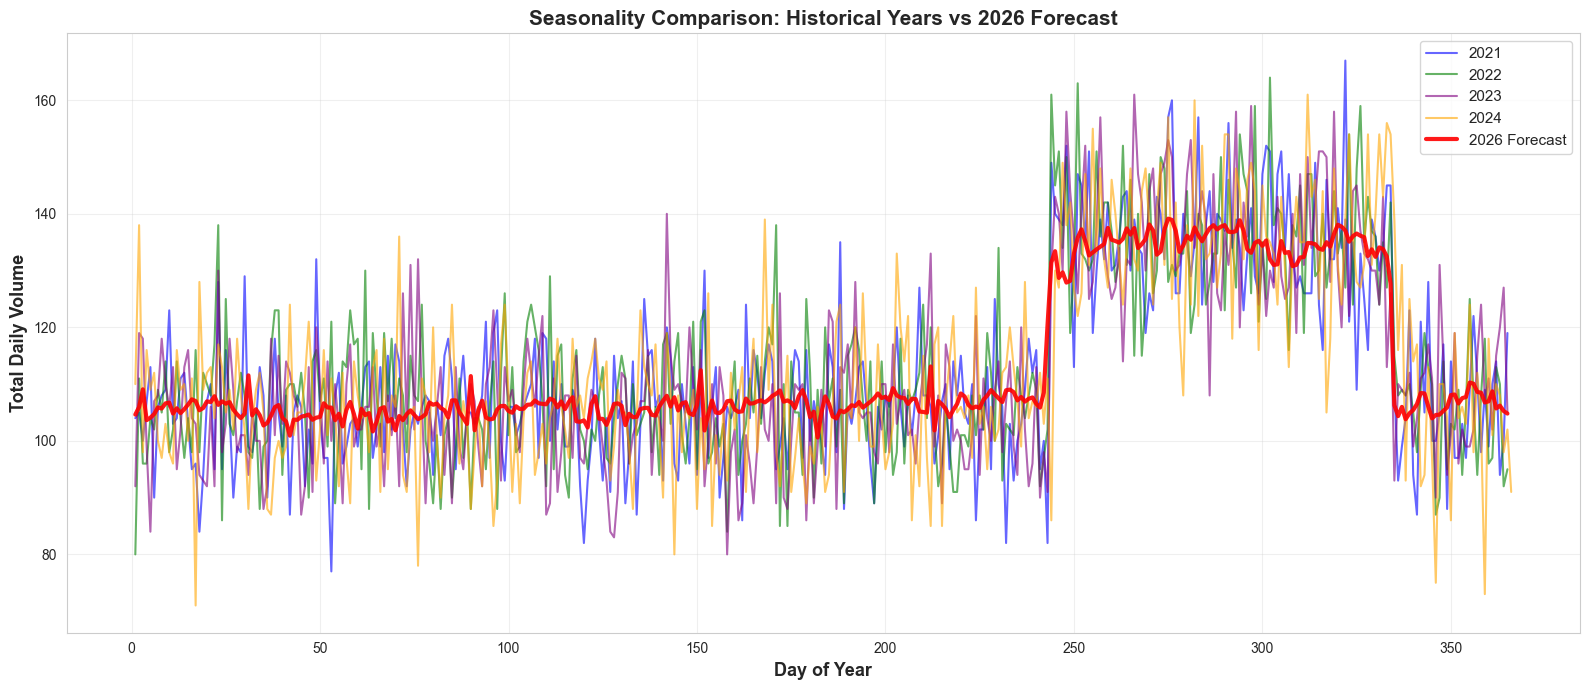


✓ Spaghetti plot shows 2026 forecast in historical context


In [14]:
# Create the Spaghetti Plot
plt.figure(figsize=(16, 7))

# Plot historical years
colors = ['blue', 'green', 'purple', 'orange']
years = [2021, 2022, 2023, 2024]

for i, year in enumerate(years):
    year_data = historical_by_year[historical_by_year['Year'] == year]
    plt.plot(
        year_data['DayOfYear'], 
        year_data['Total_Vol'],
        label=f'{year}',
        color=colors[i],
        linewidth=1.5,
        alpha=0.6
    )

# Plot 2026 forecast
plt.plot(
    agg_2026['DayOfYear'],
    agg_2026['Total_Vol'],
    label='2026 Forecast',
    color='red',
    linewidth=3,
    alpha=0.9
)

plt.xlabel('Day of Year', fontsize=13, fontweight='bold')
plt.ylabel('Total Daily Volume', fontsize=13, fontweight='bold')
plt.title(
    'Seasonality Comparison: Historical Years vs 2026 Forecast',
    fontsize=15,
    fontweight='bold'
)
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Spaghetti plot shows 2026 forecast in historical context")

### Monthly Comparison

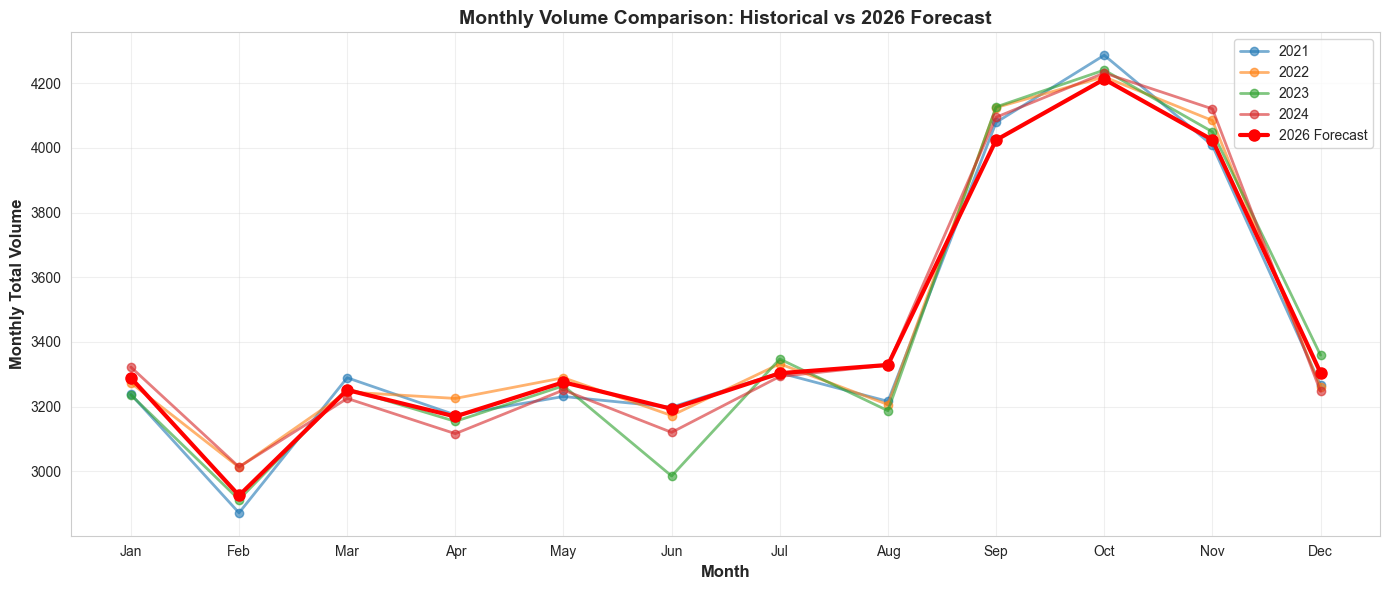

In [29]:
# Monthly aggregation for a cleaner comparison
agg_2026['Month'] = agg_2026['Date'].dt.month
monthly_2026 = agg_2026.groupby('Month')['Total_Vol'].sum()

historical_daily['Month'] = pd.to_datetime(historical_daily['booking_date']).dt.month
monthly_historical = historical_daily[
    historical_daily['Year'].isin([2021, 2022, 2023, 2024])
].groupby(['Year', 'Month'])['Total_Vol'].sum().reset_index()

# Create the plot
plt.figure(figsize=(14, 6))

# Plot historical years
for year in [2021, 2022, 2023, 2024]:
    year_data = monthly_historical[monthly_historical['Year'] == year]
    plt.plot(
        year_data['Month'],
        year_data['Total_Vol'],
        marker='o',
        label=f'{year}',
        linewidth=2,
        alpha=0.6
    )

# Plot 2026 forecast
plt.plot(
    monthly_2026.index,
    monthly_2026.values,
    marker='o',
    label='2026 Forecast',
    color='red',
    linewidth=3,
    markersize=8
)

plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Monthly Total Volume', fontsize=12, fontweight='bold')
plt.title('Monthly Volume Comparison: Historical vs 2026 Forecast', fontsize=14, fontweight='bold')
plt.xticks(
    range(1, 13),
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## Part 4: Simple Prediction Functions

Two easy-to-use functions for predictions and analysis.

### Function 1: Predict Next Day Shipment Type

In [25]:
def predict_next_shipment(company_name):
    """
    Predict the next day's shipment volumes and most likely shipment type for a company.
    
    Parameters:
    -----------
    company_name : str
        Name of the company (e.g., 'BlueDart', 'DHL', 'FedEx')
    
    Returns:
    --------
    dict : Dictionary with prediction results
        - date: Next prediction date
        - company: Company name
        - predictions: Volume for each shipment type
        - total_volume: Sum of all shipment types
        - top_shipment_type: Most likely shipment type
        - distribution: Percentage distribution
    
    Example:
    --------
    >>> result = predict_next_shipment('BlueDart')
    >>> print(result['top_shipment_type'])
    'Express'
    """
    # Check if company exists
    if company_name not in companies:
        print(f"\n❌ Error: Company '{company_name}' not found!")
        print(f"Available companies: {list(companies)}")
        return None
    
    # Get the most recent data for this company from df_clean (not df_daily)
    company_data = df_clean[df_clean['company_name'] == company_name]
    last_row = company_data.sort_values('booking_date').iloc[-1]
    
    # Calculate the next date
    next_date = last_row['booking_date'] + pd.Timedelta(days=1)
    
    # Prepare input features - use the existing feature values from last_row
    input_data = {}
    
    # Copy all lag and rolling features from the last row
    for col in target_columns:
        # These features already exist in df_clean
        input_data[f'lag_1_{col}'] = last_row[f'lag_1_{col}']
        input_data[f'lag_7_{col}'] = last_row[f'lag_7_{col}']
        input_data[f'roll_7_{col}'] = last_row[f'roll_7_{col}']
    
    # Update calendar features for the prediction date
    input_data['day_of_week'] = next_date.dayofweek
    input_data['day'] = next_date.day
    input_data['month'] = next_date.month
    
    # Add company encoding
    input_data['company_encoded'] = last_row['company_encoded']
    
    # Convert to DataFrame with correct column order
    input_df = pd.DataFrame([input_data])[feature_cols]
    
    # Make predictions for each shipment type
    predictions = {}
    total_volume = 0
    
    for ship_type in target_columns:
        pred_value = final_models[ship_type].predict(input_df)[0]
        pred_value = max(0, round(pred_value, 2))  # Non-negative and rounded
        predictions[ship_type] = pred_value
        total_volume += pred_value
    
    # Calculate percentage distribution
    if total_volume > 0:
        distribution = {k: round(100 * v / total_volume, 1) for k, v in predictions.items()}
        top_type = max(distribution, key=distribution.get)
    else:
        distribution = {k: 0.0 for k in target_columns}
        top_type = 'None'
    
    # Print formatted results
    print(f"\n{'='*70}")
    print(f"NEXT DAY SHIPMENT PREDICTION")
    print(f"{'='*70}")
    print(f"Company: {company_name}")
    print(f"Prediction Date: {next_date.strftime('%Y-%m-%d (%A)')}")
    print(f"\nPredicted Volumes:")
    print("-" * 50)
    for ship_type in target_columns:
        vol = predictions[ship_type]
        pct = distribution[ship_type]
        print(f"  {ship_type:<20}: {vol:>8.2f} units  ({pct:>5.1f}%)")
    print("-" * 50)
    print(f"  {'Total':<20}: {total_volume:>8.2f} units")
    print(f"\n✓ Most Likely Shipment Type: {top_type} ({distribution[top_type]:.1f}%)")
    print(f"{'='*70}\n")
    
    # Return results
    return {
        'date': next_date,
        'company': company_name,
        'predictions': predictions,
        'total_volume': total_volume,
        'top_shipment_type': top_type,
        'distribution': distribution
    }

print("✓ Function defined: predict_next_shipment()")

✓ Function defined: predict_next_shipment()


In [26]:
# Demo: Predict next shipment for BlueDart
result = predict_next_shipment('BlueDart')


NEXT DAY SHIPMENT PREDICTION
Company: BlueDart
Prediction Date: 2025-12-31 (Wednesday)

Predicted Volumes:
--------------------------------------------------
  Air                 :     3.65 units  ( 32.8%)
  Express             :     2.36 units  ( 21.2%)
  International       :     0.30 units  (  2.7%)
  Surface             :     4.82 units  ( 43.3%)
--------------------------------------------------
  Total               :    11.13 units

✓ Most Likely Shipment Type: Surface (43.3%)



In [27]:
# Demo: Predict for another company
result = predict_next_shipment('DHL Express')


NEXT DAY SHIPMENT PREDICTION
Company: DHL Express
Prediction Date: 2025-12-31 (Wednesday)

Predicted Volumes:
--------------------------------------------------
  Air                 :     5.93 units  ( 34.4%)
  Express             :     3.16 units  ( 18.3%)
  International       :     1.52 units  (  8.8%)
  Surface             :     6.63 units  ( 38.5%)
--------------------------------------------------
  Total               :    17.24 units

✓ Most Likely Shipment Type: Surface (38.5%)



### Function 2: Timeline Comparison with Historical Data

In [19]:
def compare_timeline(company_name, start_date, end_date):
    """
    Compare forecast timeline with historical data for a specific company.
    Shows time series graph and detailed dataframe for the selected period.
    
    Parameters:
    -----------
    company_name : str
        Name of the company (e.g., 'BlueDart', 'DHL')
    start_date : str
        Start date in format 'YYYY-MM-DD' (e.g., '2026-01-01')
    end_date : str
        End date in format 'YYYY-MM-DD' (e.g., '2026-01-31')
    
    Returns:
    --------
    DataFrame : Contains predictions for the timeline with all shipment types
    
    Example:
    --------
    >>> df = compare_timeline('BlueDart', '2026-01-01', '2026-01-31')
    >>> print(df.head())
    """
    # Check if company exists
    if company_name not in companies:
        print(f"\n❌ Error: Company '{company_name}' not found!")
        print(f"Available companies: {list(companies)}")
        return None
    
    # Convert dates to datetime
    try:
        start = pd.to_datetime(start_date)
        end = pd.to_datetime(end_date)
    except:
        print("\n❌ Error: Invalid date format. Use 'YYYY-MM-DD'")
        return None
    
    # Validate date range
    if start > end:
        print("\n❌ Error: Start date must be before end date")
        return None
    
    if start.year != 2026 or end.year != 2026:
        print("\n❌ Error: Dates must be in 2026 (forecast year)")
        return None
    
    # Filter forecast data for this company and date range
    forecast_2026['Date'] = pd.to_datetime(forecast_2026['Date'])
    company_forecast = forecast_2026[
        (forecast_2026['Company'] == company_name) &
        (forecast_2026['Date'] >= start) &
        (forecast_2026['Date'] <= end)
    ].copy()
    
    if len(company_forecast) == 0:
        print("\n❌ Error: No data found for this timeline")
        return None
    
    # Get historical data for same date range (but previous years)
    start_month_day = (start.month, start.day)
    end_month_day = (end.month, end.day)
    
    # Get historical data for comparison
    historical_company = df[df['company_name'] == company_name].copy()
    historical_company['month_day'] = list(zip(
        historical_company['booking_date'].dt.month,
        historical_company['booking_date'].dt.day
    ))
    
    # Filter by date range (month-day comparison)
    if start_month_day <= end_month_day:
        historical_filtered = historical_company[
            (historical_company['month_day'] >= start_month_day) &
            (historical_company['month_day'] <= end_month_day)
        ]
    else:
        # Handle year-end wrap around
        historical_filtered = historical_company[
            (historical_company['month_day'] >= start_month_day) |
            (historical_company['month_day'] <= end_month_day)
        ]
    
    # Aggregate historical by date and shipment type
    historical_agg = historical_filtered.groupby(
        ['booking_date', 'shipment_type']
    ).size().reset_index(name='volume')
    
    historical_pivot = historical_agg.pivot_table(
        index='booking_date',
        columns='shipment_type',
        values='volume',
        fill_value=0
    ).reset_index()
    
    historical_pivot['year'] = historical_pivot['booking_date'].dt.year
    historical_pivot['month_day'] = historical_pivot['booking_date'].dt.strftime('%m-%d')
    
    # Create the comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    
    for i, ship_type in enumerate(target_columns):
        ax = axes[i]
        
        # Plot historical years
        for year in sorted(historical_pivot['year'].unique()):
            year_data = historical_pivot[historical_pivot['year'] == year]
            if ship_type in year_data.columns:
                ax.plot(
                    year_data['month_day'],
                    year_data[ship_type],
                    marker='o',
                    label=f'{year}',
                    alpha=0.6,
                    linewidth=1.5
                )
        
        # Plot 2026 forecast
        company_forecast['month_day'] = company_forecast['Date'].dt.strftime('%m-%d')
        ax.plot(
            company_forecast['month_day'],
            company_forecast[ship_type],
            marker='o',
            label='2026 Forecast',
            color='red',
            linewidth=2.5,
            markersize=6
        )
        
        ax.set_title(f'{ship_type} Shipments', fontsize=13, fontweight='bold')
        ax.set_xlabel('Date (MM-DD)', fontsize=10)
        ax.set_ylabel('Volume', fontsize=10)
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        
        # Show only every nth label to avoid crowding
        n = max(1, len(company_forecast) // 10)
        for idx, label in enumerate(ax.xaxis.get_ticklabels()):
            if idx % n != 0:
                label.set_visible(False)
    
    plt.suptitle(
        f'Timeline Comparison for {company_name}\n{start_date} to {end_date}',
        fontsize=15,
        fontweight='bold',
        y=1.00
    )
    plt.tight_layout()
    plt.show()
    
    # Prepare output dataframe
    output_df = company_forecast[[
        'Date', 'Air', 'Express', 'International', 'Surface', 'Total_Vol', 'Top_Route'
    ]].copy()
    output_df['Date'] = output_df['Date'].dt.strftime('%Y-%m-%d')
    output_df = output_df.reset_index(drop=True)
    
    # Print summary
    print(f"\n{'='*70}")
    print(f"TIMELINE COMPARISON SUMMARY")
    print(f"{'='*70}")
    print(f"Company: {company_name}")
    print(f"Period: {start_date} to {end_date}")
    print(f"Total Days: {len(output_df)}")
    print(f"\nForecast Statistics:")
    print("-" * 70)
    print(f"  Total Volume: {output_df['Total_Vol'].sum():.2f}")
    print(f"  Average Daily Volume: {output_df['Total_Vol'].mean():.2f}")
    print(f"  Peak Day: {output_df.loc[output_df['Total_Vol'].idxmax(), 'Date']} ({output_df['Total_Vol'].max():.2f})")
    print(f"  Lowest Day: {output_df.loc[output_df['Total_Vol'].idxmin(), 'Date']} ({output_df['Total_Vol'].min():.2f})")
    print(f"\nShipment Type Breakdown:")
    print("-" * 70)
    for ship_type in target_columns:
        total = output_df[ship_type].sum()
        avg = output_df[ship_type].mean()
        print(f"  {ship_type:<20}: Total = {total:>8.2f}, Avg = {avg:>6.2f}")
    print(f"{'='*70}\n")
    
    # Display dataframe
    print("Detailed Forecast Data:")
    print("-" * 70)
    display(output_df)
    
    return output_df

print("✓ Function 2 defined: compare_timeline()")

✓ Function 2 defined: compare_timeline()


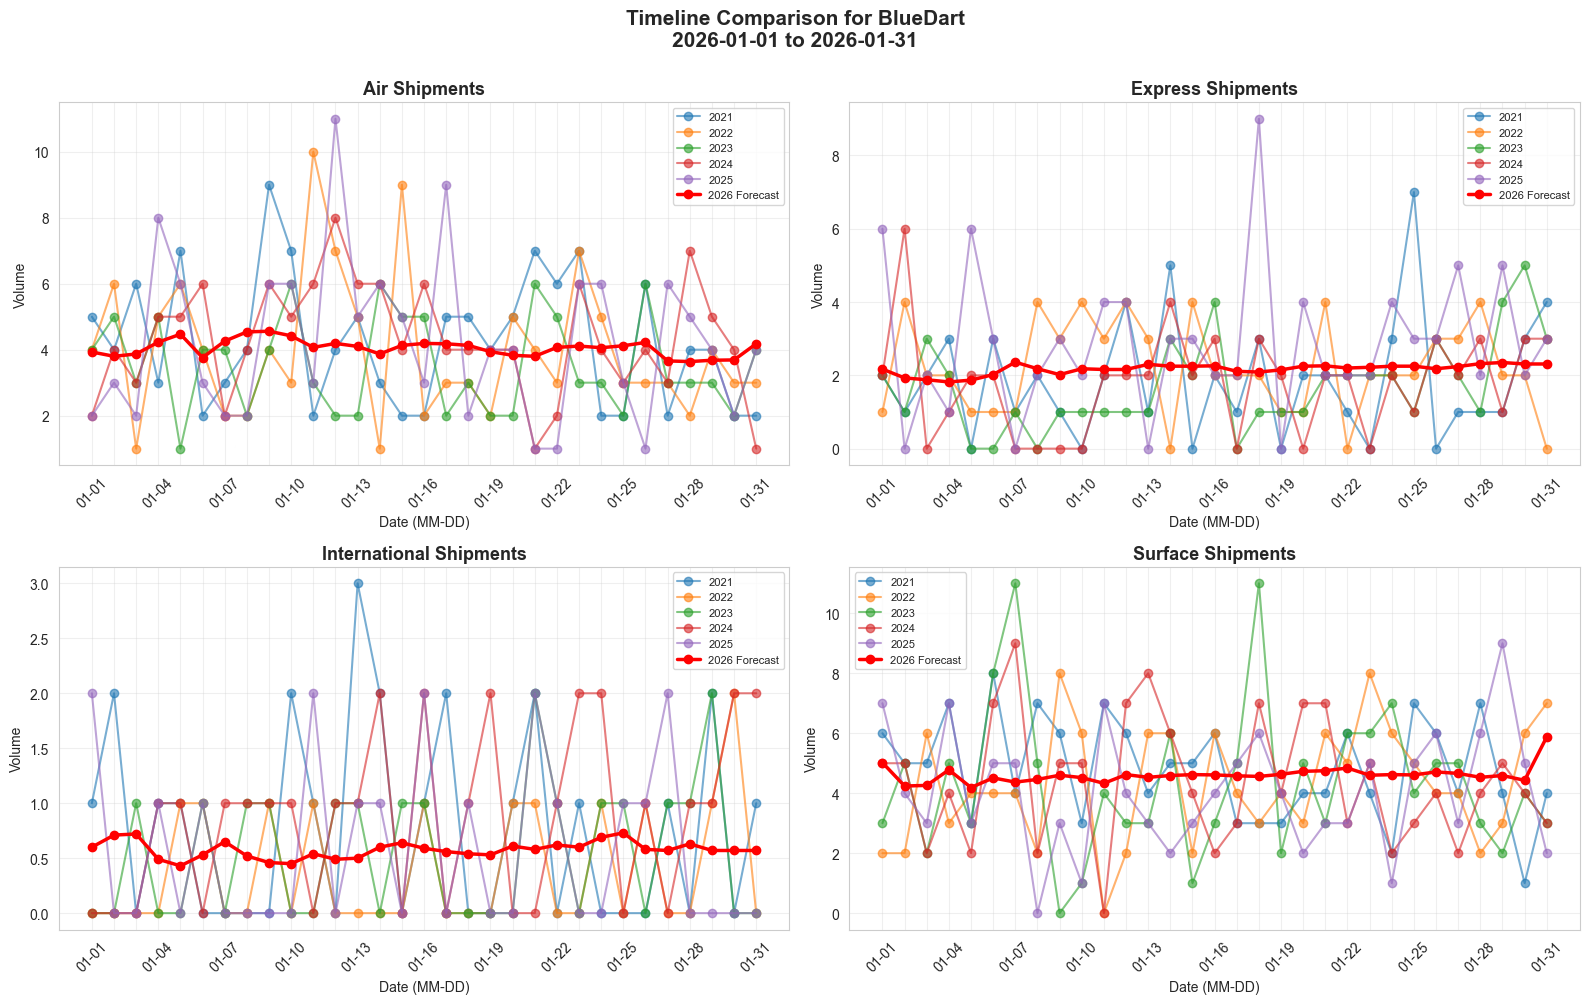


TIMELINE COMPARISON SUMMARY
Company: BlueDart
Period: 2026-01-01 to 2026-01-31
Total Days: 31

Forecast Statistics:
----------------------------------------------------------------------
  Total Volume: 353.81
  Average Daily Volume: 11.41
  Peak Day: 2026-01-31 (12.95)
  Lowest Day: 2026-01-02 (10.67)

Shipment Type Breakdown:
----------------------------------------------------------------------
  Air                 : Total =   125.70, Avg =   4.05
  Express             : Total =    67.30, Avg =   2.17
  International       : Total =    17.87, Avg =   0.58
  Surface             : Total =   142.97, Avg =   4.61

Detailed Forecast Data:
----------------------------------------------------------------------


,Date,Air,Express,International,Surface,Total_Vol,Top_Route
0,2026-01-01,3.93,2.17,0.60,5.02,11.71,Surface
1,2026-01-02,3.80,1.93,0.71,4.24,10.67,Surface
2,2026-01-03,3.87,1.88,0.72,4.26,10.74,Surface
3,2026-01-04,4.23,1.82,0.49,4.78,11.32,Surface
4,2026-01-05,4.47,1.87,0.43,4.19,10.96,Air
5,2026-01-06,3.76,2.02,0.53,4.51,10.81,Surface
6,2026-01-07,4.26,2.36,0.65,4.37,11.63,Surface
7,2026-01-08,4.54,2.18,0.52,4.46,11.70,Air
8,2026-01-09,4.56,2.02,0.46,4.60,11.63,Surface
9,2026-01-10,4.42,2.18,0.45,4.52,11.56,Surface


In [20]:
# Demo: Compare January 2026 for BlueDart
january_data = compare_timeline('BlueDart', '2026-01-01', '2026-01-31')

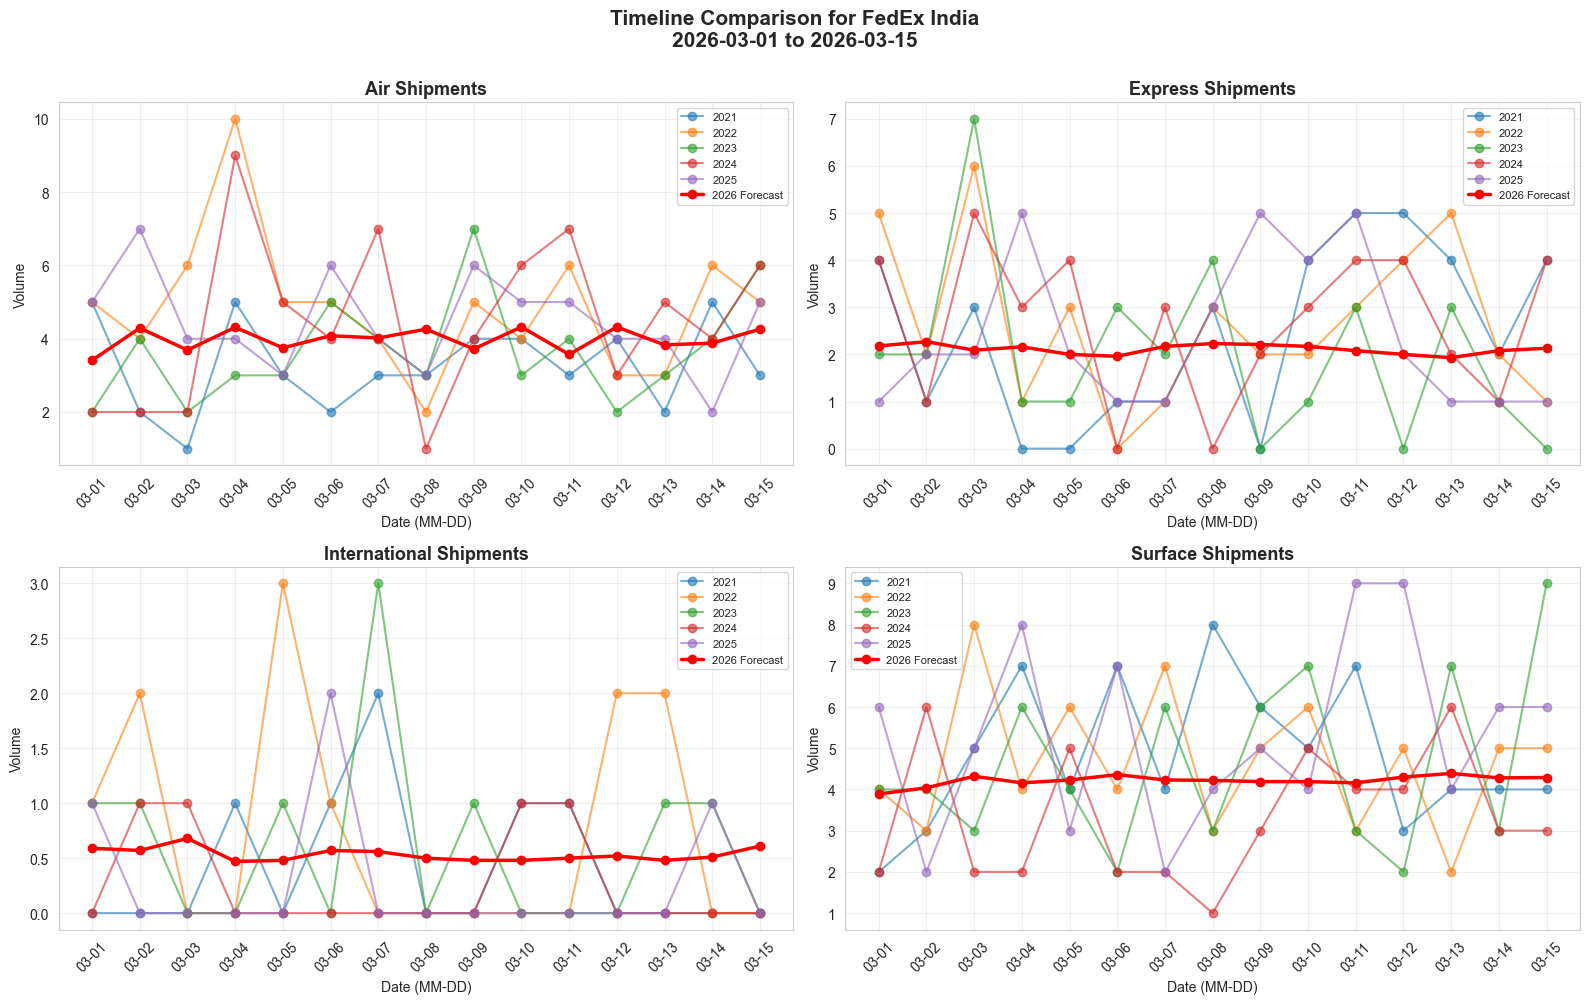


TIMELINE COMPARISON SUMMARY
Company: FedEx India
Period: 2026-03-01 to 2026-03-15
Total Days: 15

Forecast Statistics:
----------------------------------------------------------------------
  Total Volume: 162.59
  Average Daily Volume: 10.84
  Peak Day: 2026-03-15 (11.28)
  Lowest Day: 2026-03-01 (10.07)

Shipment Type Breakdown:
----------------------------------------------------------------------
  Air                 : Total =    59.71, Avg =   3.98
  Express             : Total =    31.66, Avg =   2.11
  International       : Total =     8.00, Avg =   0.53
  Surface             : Total =    63.25, Avg =   4.22

Detailed Forecast Data:
----------------------------------------------------------------------


,Date,Air,Express,International,Surface,Total_Vol,Top_Route
0,2026-03-01,3.41,2.18,0.59,3.89,10.07,Surface
1,2026-03-02,4.29,2.27,0.57,4.04,11.17,Air
2,2026-03-03,3.69,2.09,0.68,4.32,10.78,Surface
3,2026-03-04,4.31,2.16,0.47,4.16,11.10,Air
4,2026-03-05,3.75,2.00,0.48,4.23,10.46,Surface
5,2026-03-06,4.08,1.96,0.57,4.36,10.96,Surface
6,2026-03-07,4.02,2.17,0.56,4.23,10.98,Surface
7,2026-03-08,4.26,2.23,0.50,4.22,11.21,Air
8,2026-03-09,3.72,2.21,0.48,4.19,10.59,Surface
9,2026-03-10,4.32,2.17,0.48,4.19,11.16,Air


In [23]:
# Demo: Compare a different timeline
march_data = compare_timeline('FedEx India', '2026-03-01', '2026-03-15')

---
## Forecasting Summary

In [24]:
print("="*70)
print("FORECASTING SUMMARY")
print("="*70)

print("\n1. FINAL MODEL TRAINING")
print("   ✓ Models retrained on complete dataset (2021-2025)")
print(f"   ✓ XGBoost models: {len(final_models)} shipment types")

print("\n2. 2026 RECURSIVE FORECAST")
print(f"   ✓ Days forecasted: {len(dates_2026)}")
print(f"   ✓ Total predictions: {len(predictions_2026):,}")
print(f"   ✓ Date range: {dates_2026[0].date()} to {dates_2026[-1].date()}")

print("\n3. SEASONALITY ANALYSIS")
print("   ✓ Spaghetti plot created (historical + 2026)")
print("   ✓ Historical context: 2021-2024")

print("\n4. PREDICTION FUNCTIONS")
print("   ✓ Function 1: predict_next_shipment(company_name)")
print("      - Predicts next day's shipment volumes")
print("      - Shows most likely shipment type")
print("   ✓ Function 2: compare_timeline(company, start_date, end_date)")
print("      - Compares forecast with historical data")
print("      - Shows time series graphs for all shipment types")
print("      - Returns detailed dataframe")

print("\n5. OUTPUT FILES")
print("   ✓ forecast_2026.csv: Complete 365-day forecast")
print("   ✓ All predictions include shipment type breakdown")

print("\n" + "="*70)
print("✓ 2026 FORECASTING COMPLETE")
print("="*70)

# Final statistics
print("\n2026 FORECAST STATISTICS:")
print(f"  Total predicted volume: {agg_2026['Total_Vol'].sum():,.0f}")
print(f"  Average daily volume: {agg_2026['Total_Vol'].mean():.2f}")
print(f"  Peak day: {agg_2026.loc[agg_2026['Total_Vol'].idxmax(), 'Date'].date()} ({agg_2026['Total_Vol'].max():.0f})")
print(f"  Lowest day: {agg_2026.loc[agg_2026['Total_Vol'].idxmin(), 'Date'].date()} ({agg_2026['Total_Vol'].min():.0f})")

print("\nShipment Type Breakdown (2026 Total):")
for t in target_columns:
    total = agg_2026[t].sum()
    pct = 100 * total / agg_2026['Total_Vol'].sum()
    print(f"  {t:<15}: {total:>10,.0f} ({pct:>5.1f}%)")

FORECASTING SUMMARY

1. FINAL MODEL TRAINING
   ✓ Models retrained on complete dataset (2021-2025)
   ✓ XGBoost models: 4 shipment types

2. 2026 RECURSIVE FORECAST
   ✓ Days forecasted: 365
   ✓ Total predictions: 2,920
   ✓ Date range: 2026-01-01 to 2026-12-31

3. SEASONALITY ANALYSIS
   ✓ Spaghetti plot created (historical + 2026)
   ✓ Historical context: 2021-2024

4. PREDICTION FUNCTIONS
   ✓ Function 1: predict_next_shipment(company_name)
      - Predicts next day's shipment volumes
      - Shows most likely shipment type
   ✓ Function 2: compare_timeline(company, start_date, end_date)
      - Compares forecast with historical data
      - Shows time series graphs for all shipment types
      - Returns detailed dataframe

5. OUTPUT FILES
   ✓ forecast_2026.csv: Complete 365-day forecast
   ✓ All predictions include shipment type breakdown

✓ 2026 FORECASTING COMPLETE

2026 FORECAST STATISTICS:
  Total predicted volume: 41,300
  Average daily volume: 113.15
  Peak day: 2026-10-02 